[Jupyter Book](https://geo-smart.github.io/oceanography/intro.html) and [GitHub repo](https://github.com/geo-smart/oceanography).


# Data Loader


The data referenced in this Jupyter Book exceed recommended GitHub repository capacity. As a result
this notebook loads data from the cloud as needed to a directory (folder) external to the repository.
This directory *appears* to be part of the repository by means of a symbolic link. 


The data source is the **interactive oceans** zarr-format collections found via the Python `s3fs` library
under the name `ooi-data`.


Consequently the data load process can be summarized as 'I created a data folder with a couple Gigabytes
of available capacity, I set up a symbolic link from within the Jupyter Book **`oceanography`** repository
(which I created using `git clone`); and then I connected to the cloud using the Python `s3fs` library
to access data of interest.'


The two important preliminary steps (after cloning this repository) are creating that landing space 
for the data and enabling ingest processing in this notebook/chapter. These steps take about five minutes.


> 1. **Setting up a landing site for data** The repo data folder resides in the `chapters` folder with a path like
`data/rca/sensors/osb`. The necessary data volume is about 1GB. Supposer your home directory is `/home/roger`.
The the full path to this folder, assuming you have the `oceanography` repo installed in your home
folder, would be `/home/roger/oceanography/books/chapters/data/rca/sensors/osb`. Notice that this is
*inside* your repository directory. This will work fine as long as you do not have plans to push the
repo back to GitHub. Why? Because loading in 1GB of data is considered impolite. To this end you can
instead create an `osb` folder that is external to the repository and then make a symbolic link to 
that external folder. An example command sequence:


```
cd ~
mkdir osb
cd oceanography/book/chapters/data/rca/sensors
rmdir osb
ln -s /home/roger/osb ./osb
```


> This creates a link in your `sensors` folder that points to the external `osb` folder. 


> 2. Enable the ingest process: Set `doIngest = True` in the code cell below. 


With these two steps done (and presuming you have `s3fs` installed in your environment)
you are ready to run the cells in this notebook that connect to the sensor stream
datasets. At the moment there are 15 sensors of interest with more pending. One
instrument, the 83-channel spectrophotometer, is treated separately.


> Pro tips:
> - Possible issue if running an ingest cell a second time: The code may try and fail to clobber an existing data file
> - charting is done from locally saved data, not from cloud data
>     - improvement: charting code ought to check for the local file existence first
> - improvement: the code should be consolidated as monolithic


For more on Zarr store use see [Joe Duprey's gist on GitHub](https://gist.github.com/jdduprey/7d5735d6de9c0c46fd16b78ee865f612).


## Shallow Profiler Oregon Slope Base January 2022

In [1]:
import netCDF4
import xarray as xr
import s3fs
from   shallowprofiler import *
from   charts import *
from   sys import exit
from   os import path


doIngest = True

fs = s3fs.S3FileSystem(anon=True)

streamlist = fs.listdir('ooi-data', detail = False)

profiles = ReadProfileMetadata()

# 'streamlist' as the last line of the cell will list out the streams; organized by site and instrument
# For more details on the nomenclature run the following cell.

def InstrumentBreakout(s):
    print('Field breakout:', s[9:11], s[11:13], s[13:15], s[15:17], s[18:20], s[20:22], s[22:23], s[24:26], \
          s[27:32], s[32:33], s[33:36], s[46:])

print('List Oregon Slope Base Profiler streams:\n')
for s in streamlist:
    if 'SF01A' in s: print(s)
print()
print('Translation:')
print('  CTDPF / ctdpf                 CTD')
print('  PHSEN / phsen                 pH')
print('  FLORT / flort                 Fluorometer { FDOM, Chlor-A, Backscatter }')
print('  OPTAA / optaa                 Spectrophotometer') 
print('  PARAD / parad                 PAR')
print('  SPKIR / spkir                 Spectral Irradiance')
print('  NUTNR / nutnr_a_dark_sample   Nitrate: Dark sample (explain please)')
print('  NUTNR / nutnr_a_sample        Nitrate: ...')
print('  VELPT / velpt                 Velocity (current) ambiguous: on SCIP or affixed to platform?')
print('  PCO2W / pco2w                 pCO2')
print()

stream_choice = 15       # the 15th element in the file list corresponds to the Shallow Profiler, Oregon Slope Base site

print()
print('Full stream name:', streamlist[stream_choice])
print()
InstrumentBreakout(streamlist[stream_choice])
print()
print('The first field has CE for Coastal Endurance or RS for Regional Cabled Array.')
print('The Oregon Offshore site is a CE site; the other two are RS sites.')
print('Fields 5, 6 and 7 give us shallow profiler site and choice of profiler or platform.')
print()
indenter = 4
print(' '*indenter + 'PC 01 B --> Oregon Offshore 200m Platform')
print(' '*indenter + 'SF 01 B --> Oregon Offshore Profiler')
print(' '*indenter + 'PC 01 A --> Oregon Slope Base 200m Platform')
print(' '*indenter + 'SF 01 A --> Oregon Slope Base Profiler')
print(' '*indenter + 'PC 03 A --> Axial Base 200m Platform')
print(' '*indenter + 'SF 03 A --> Axial Base Profiler')
print()
print('Non-shallow-profiler examples:')
print('  DP O3 A is the Axial Base Deep Profiler')
print('  LJ 01 A is the Oregon Slope Base Seafloor')
print()

def loadData(stream_name):
    fs = s3fs.S3FileSystem(anon=True)
    zarr_store = fs.get_mapper(stream_name)
    ds = xr.open_zarr(zarr_store, consolidated=True)
    return ds

def ShallowProfilerDataReduce(ds, t0, t1, keepers, rename):
    """
    From an XArray Dataset for a shallow profiler instrument stream: Clean up and return a 
    subset of the data also in Dataset format. 
      - constrain the time range to the interval t0 - t1
      - verify one dimension/coordinate: 'time'
          - others are removed via .drop_dims()
      - from a list of keeper data variables: rename them
      - drop the other data variables
      - drop all the attributes
    """
    if not len(ds.dims) == 1: 
        for dim in ds.dims:
            if not dim == 'time':
                ds = ds.drop_dims(dim)
        if not len(ds.dims) == 1: return False, "time dimension only code failed"
    if not list(dict(ds.dims))[0] == 'time': 
        return False, "Dataset dim is not 'time' (as assumed)"
    if not len(ds.coords) == 1: 
        return False, "Dataset coords count is not 1 (as assumed)"
    if not list(dict(ds.coords))[0] == 'time': 
        return False, "Dataset coord is not 'time' (as assumed)"
    
    ds = ds.sel(time=slice(t0, t1))               # time window
    
    for s in ds.data_vars:
        if not s in keepers: ds = ds.drop(s)                              # drop extraneous data vars
    for s in ds.data_vars: ds = ds.rename({s:rename[keepers.index(s)]})   # rename the others
    a = [s for s in ds.attrs]
    for p in a: ds.attrs.pop(p)
    return ds, 'looks ok'

osb_profiler_streams = [sname for sname in streamlist if 'SF01A' in sname]

for s in osb_profiler_streams: 
    if 'ctdpf' in s: print('CTD:', s)
    if 'velpt' in s: print('Current:', s)
    
print("There are", len(osb_profiler_streams), "Oregon Slope Base profiler streams")


Jupyter Notebook running Python 3
List Oregon Slope Base Profiler streams:

ooi-data/RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample
ooi-data/RS01SBPS-SF01A-2D-PHSENA101-streamed-phsen_data_record
ooi-data/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record
ooi-data/RS01SBPS-SF01A-3B-OPTAAD101-streamed-optaa_sample
ooi-data/RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample
ooi-data/RS01SBPS-SF01A-3D-SPKIRA101-streamed-spkir_data_record
ooi-data/RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_dark_sample
ooi-data/RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_sample
ooi-data/RS01SBPS-SF01A-4B-VELPTD102-streamed-velpt_velocity_data
ooi-data/RS01SBPS-SF01A-4F-PCO2WA101-streamed-pco2w_a_sami_data_record

Translation:
  CTDPF / ctdpf                 CTD
  PHSEN / phsen                 pH
  FLORT / flort                 Fluorometer { FDOM, Chlor-A, Backscatter }
  OPTAA / optaa                 Spectrophotometer
  PARAD / parad                 PAR
  SPKIR / spkir                 S

### Go through all 10 osb profiler streams in sequence

In this order: 

- ctdpf
- phsen
- flort
- optaa
- parad
- spkir
- nutnr_a_dark_sample
- nutnr_a_sample
- velpt
- pco2w

## XXX This Section In Development XXX


(This code will do the data load as a cycle through the various instruments.)


Scroll down past this to continue: Sequence of instrument-based data loads.

In [11]:
streamlist_profiler_site_keys = {'osb':'SF01A', 'oof':'SF01B', 'axb':'SF03A'}
streamlist_platform_site_keys = {'osb':'PC01A', 'oof':'PC01B', 'axb':'PC03A'}

site_key = 'osb'

profiler_instrument_streams = [sname for sname in streamlist if streamlist_profiler_site_keys[site_key] in sname]

In [21]:
official_instrument_keys = ['ctdpf', 'phsen', 'flort', 'nutnr_a_dark_sample', 'nutnr_a_sample', 'velpt', 'pco2w']
official_unused_instrument_keys = 

doIngest = True
do_ingest = [doIngest]*len(instrument_keys)
sensor_official_names = [['corrected_dissolved_oxygen','sea_water_density','sea_water_electrical_conductivity','sea_water_practical_salinity','sea_water_temperature'], \
                         ['ph_seawater'], \
                         ['fluorometric_cdom','fluorometric_chlorophyll_a','optical_backscatter'], \
                         ['nitrate_concentration'], \
                         ['salinity_corrected_nitrate'], \
                         ['velpt_d_upward_velocity','velpt_d_northward_velocity','velpt_d_eastward_velocity'], 
                         ['pco2_seawater']]
sensor_informal_names = [['do','density','conductivity','salinity','temp'], ['ph'], ['fdom','chlora','backscatter'], ['nitrate_dark'], ['nitrate'], ['up','north','east'], ['pco2']]
sensor_official_depth = ['sea_water_pressure','int_ctd_pressure','int_ctd_pressure','int_ctd_pressure','int_ctd_pressure','int_ctd_pressure','int_ctd_pressure']

nSensors      = [len(sensorlist) for sensorlist in sensor_official_names]
nSensorsCheck = [len(sensorlist) for sensorlist in sensor_informal_names]
if not nSensors == nSensorsCheck:
    print("Sensor descriptions official/informal do not align")
    exit()

In [13]:
for ik in instrument_keys:                               # going in order CTD ... pCO2, ik is a string like 'ctdpf'
    idx = instrument_keys.index(ik)                      # idx is an instrument index
    for s in profiler_instrument_streams:                # profiler_instrument_streams is a list of 10 long stream names
        if ik in s:                                      # match up the one we want 
            key = profiler_instrument_streams.index(s)   # key is the index of the stream of interest
            print('Found instrument ' + ik + ': ' + s)
            if doIngest[idx]:
                ds = loadData(
                for sensor in sensor_official_names[idx]:
                    sensor_index = sensor_official_names[idx].index(sensor)
                    
            else:
                print("Skipping ingest on this instrument.")
            

Found instrument ctdpf: ooi-data/RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample
Found instrument phsen: ooi-data/RS01SBPS-SF01A-2D-PHSENA101-streamed-phsen_data_record
Found instrument flort: ooi-data/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record
Found instrument nutnr_a_dark_sample: ooi-data/RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_dark_sample
Found instrument nutnr_a_sample: ooi-data/RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_sample
Found instrument velpt: ooi-data/RS01SBPS-SF01A-4B-VELPTD102-streamed-velpt_velocity_data
Found instrument pco2w: ooi-data/RS01SBPS-SF01A-4F-PCO2WA101-streamed-pco2w_a_sami_data_record


# XXX End of In Development Section XXX

This is the development code

#### 1 of 10: **ctdpf** i.e. CTD



In [2]:
for s in osb_profiler_streams: 
    if 'ctdpf' in s: 
        print('Found CTD:', s)
        stream_ctd = s
        break
        
if doIngest:
    ds = loadData(stream_ctd)                             # lazy load
    t0, t1 = '2022-01-01T00', '2022-12-31T23'             # January 2022
    ds = ds.sel(time=slice(t0, t1))                       # Subset the full time range to one month
    print(ds.time[0], '              ', ds.time[-1])      # verify selected one month time range
    ds                                                    # get a 'data variable' list of sensors/metadata for this instrument

Found CTD: ooi-data/RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample
<xarray.DataArray 'time' ()>
array('2022-01-01T00:00:00.097717760', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-01-01T00:00:00.097717760
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time                <xarray.DataArray 'time' ()>
array('2022-12-31T23:59:59.150689280', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-12-31T23:59:59.150689280
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time


We pull five sensor time series datasets from the CTD stream. These are named data variables and
they will be renamed using the table found in the **Data** chapter. Each sensor dataset also contains
time (as dimension/coordinate) and depth (as a second data variable). 
Depth is the `sea_water_pressure` data variable renamed. 

```
corrected_dissolved_oxygen              do              depth  
sea_water_density                       density         depth                     
sea_water_electrical_conductivity       conductivity    depth       
sea_water_practical_salinity            salinity        depth
sea_water_temperature                   temp            depth
```

In [3]:
if doIngest:
    t0, t1 = '2022-01-01T00', '2022-01-31T23'
    ds_do, reply1           = ShallowProfilerDataReduce(ds, t0, t1, ['corrected_dissolved_oxygen', 'sea_water_pressure'], ['do', 'depth'])
    ds_density, reply2      = ShallowProfilerDataReduce(ds, t0, t1, ['sea_water_density', 'sea_water_pressure'], ['density', 'depth'])
    ds_conductivity, reply3 = ShallowProfilerDataReduce(ds, t0, t1, ['sea_water_electrical_conductivity', 'sea_water_pressure'], ['conductivity', 'depth'])
    ds_salinity, reply4    = ShallowProfilerDataReduce(ds, t0, t1, ['sea_water_practical_salinity', 'sea_water_pressure'], ['salinity', 'depth'])
    ds_temp, reply5        = ShallowProfilerDataReduce(ds, t0, t1, ['sea_water_temperature', 'sea_water_pressure'], ['temp', 'depth'])

    if False: 
        print(reply1)
        print(reply2)
        print(reply3)
        print(reply4)
        print(reply5)

    if False: 
        print(ds_do)
        print(ds_density)
        print(ds_conductivity)
        print(ds_salinity)
        print(ds_temp)

    ds_do.to_netcdf('./data/rca/sensors/osb/do_jan_2022.nc') 
    ds_density.to_netcdf('./data/rca/sensors/osb/density_jan_2022.nc') 
    ds_conductivity.to_netcdf('./data/rca/sensors/osb/conductivity_jan_2022.nc') 
    ds_salinity.to_netcdf('./data/rca/sensors/osb/salinity_jan_2022.nc') 
    ds_temp.to_netcdf('./data/rca/sensors/osb/temp_jan_2022.nc') 

Attempting 1 charts



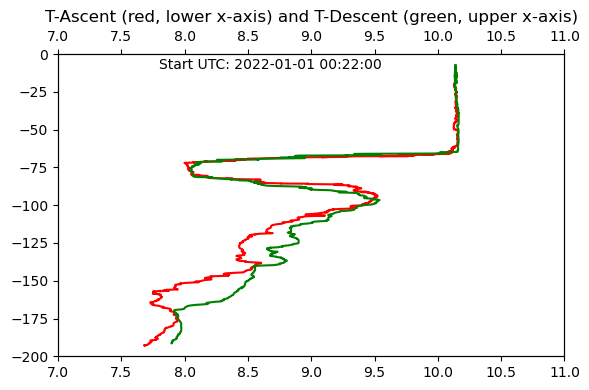

In [4]:
ds_temp = xr.open_dataset('./data/rca/sensors/osb/temp_jan_2022.nc')

# temperature: ascent versus descent
fig,axs = ChartTwoSensors(profiles, [ranges['temp'], ranges['temp']], [0], 
                          ds_temp.temp, -ds_temp.depth, 'T-Ascent',   colors['temp'],    'ascent',
                          ds_temp.temp, -ds_temp.depth, 'T-Descent',  'green',           'descent', 6, 4)

#### 2 of 10: **phsen** i.e. pH

In [5]:
if doIngest:
    instrument_key = 'phsen'
    for s in osb_profiler_streams: 
        if instrument_key in s: 
            print('Found this instrument stream:', s)
            instrument_stream = s
            break

    ds = loadData(instrument_stream)                      # lazy load
    t0, t1 = '2022-01-01T00', '2022-12-31T23'             # January 2022
    ds = ds.sel(time=slice(t0, t1))                       # Subset the full time range to one month
    print(ds.time[0], '              ', ds.time[-1])      # verify selected one month time range
    ds                                                    # get a 'data variable' list of sensors/metadata for this instrument

Found this instrument stream: ooi-data/RS01SBPS-SF01A-2D-PHSENA101-streamed-phsen_data_record
<xarray.DataArray 'time' ()>
array('2022-01-01T02:12:11.470588928', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-01-01T02:12:11.470588928
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time                <xarray.DataArray 'time' ()>
array('2022-12-06T19:55:50.204456448', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-12-06T19:55:50.204456448
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time


We pull one sensor time series dataset from this stream. See the CTD section above
and the Data chapter. The data variable of interest is `ph_seawater` which will be
renamed ph. Depth will be a rename of the `int_ctd_pressure` data variable. 
This stream has multiple dimensions so there is a preliminary step to isolate
just time, ph_seawater and int_ctd_pressure. 

In [6]:
if doIngest:
    t0, t1 = '2022-01-01T00', '2022-01-31T23'
    ds_ph, reply = ShallowProfilerDataReduce(ds, t0, t1, ['ph_seawater', 'int_ctd_pressure'], ['ph', 'depth'])
    print(reply)
    print(ds_ph)

    ds_ph.to_netcdf('./data/rca/sensors/osb/ph_jan_2022.nc') 

looks ok
<xarray.Dataset>
Dimensions:  (time: 1003)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01T02:12:11.470588928 ... 2022-01-...
Data variables:
    depth    (time) float64 ...
    ph       (time) float64 ...


Attempting 4 charts



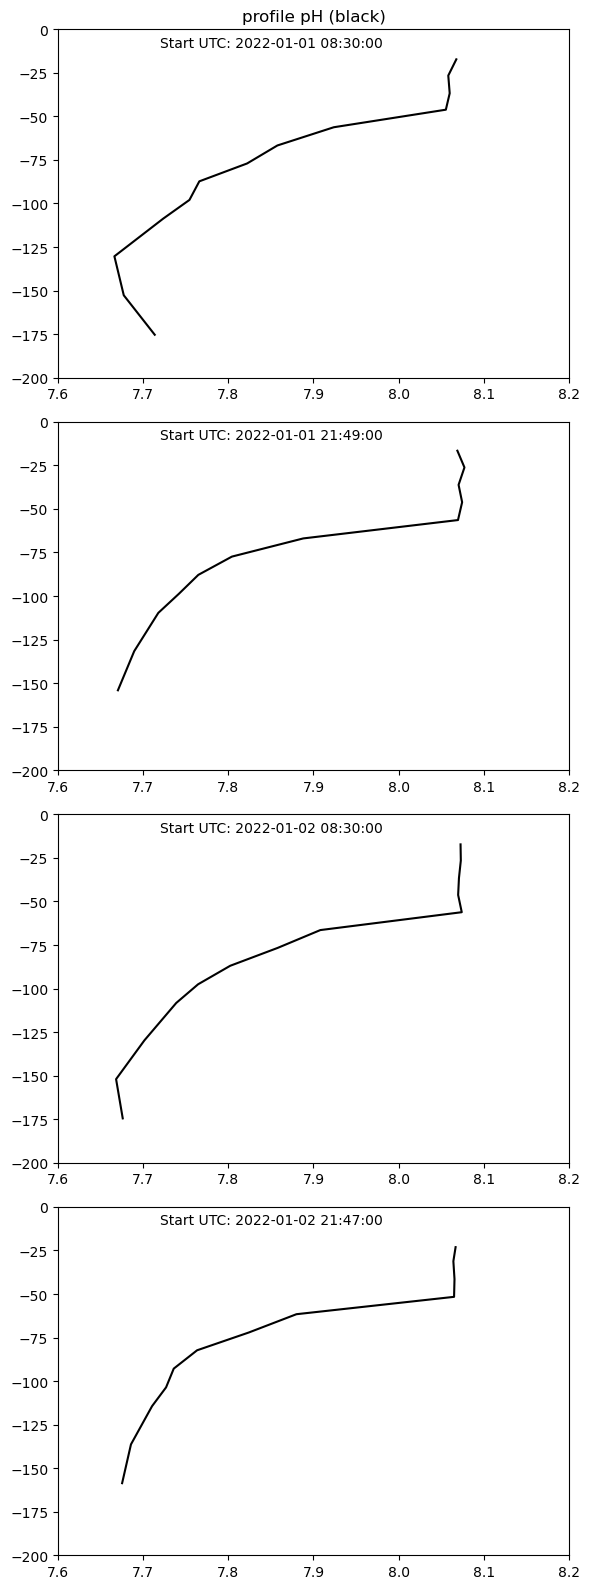

In [7]:
ds_ph = xr.open_dataset('./data/rca/sensors/osb/ph_jan_2022.nc')

# ph: is measured on descent
fig, axes = ChartSensor(profiles, ranges['ph'], [3, 8, 12, 17], ds_ph.ph, -ds_ph.depth, 'profile pH', 'black', 'descent', 6, 4)

#### 3 of 10: **flort** i.e. fluorometer: Chlor-A, FDOM, particulate backscatter

In [8]:
if doIngest:
    instrument_key = 'flort'
    for s in osb_profiler_streams: 
        if instrument_key in s: 
            print('Found this instrument stream:', s)
            instrument_stream = s
            break

    ds = loadData(instrument_stream)                      # lazy load
    t0, t1 = '2022-01-01T00', '2022-12-31T23'             # January 2022
    ds = ds.sel(time=slice(t0, t1))                       # Subset the full time range to one month
    print(ds.time[0], '              ', ds.time[-1])      # verify selected one month time range
    ds                                                    # get a 'data variable' list of sensors/metadata for this instrument

Found this instrument stream: ooi-data/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record
<xarray.DataArray 'time' ()>
array('2022-01-01T00:00:00.702079488', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-01-01T00:00:00.702079488
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time                <xarray.DataArray 'time' ()>
array('2022-12-31T23:58:28.044592128', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-12-31T23:58:28.044592128
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time


We pull three sensor time series datasets from this stream. See the CTD section above
and the Data chapter. Data variables: 

```
fluorometric_cdom           >      fdom, depth
fluorometric_chlorophyll_a  >      chlora, depth
optical_backscatter         >      backscatter, depth
```

Depth from `int_ctd_pressure`.

In [9]:
if doIngest:
    t0, t1 = '2022-01-01T00', '2022-01-31T23'
    ds_fdom, reply        = ShallowProfilerDataReduce(ds, t0, t1, ['fluorometric_cdom', 'int_ctd_pressure'], ['fdom', 'depth'])
    ds_chlora, reply      = ShallowProfilerDataReduce(ds, t0, t1, ['fluorometric_chlorophyll_a', 'int_ctd_pressure'], ['chlora', 'depth'])
    ds_backscatter, reply = ShallowProfilerDataReduce(ds, t0, t1, ['optical_backscatter', 'int_ctd_pressure'], ['backscatter', 'depth'])

    ds_fdom.to_netcdf('./data/rca/sensors/osb/fdom_jan_2022.nc')
    ds_chlora.to_netcdf('./data/rca/sensors/osb/chlora_jan_2022.nc')
    ds_backscatter.to_netcdf('./data/rca/sensors/osb/backscatter_jan_2022.nc')

Attempting 1 charts

Attempting 1 charts

Attempting 1 charts



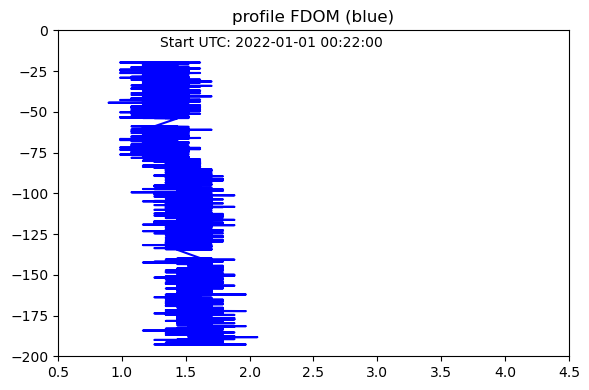

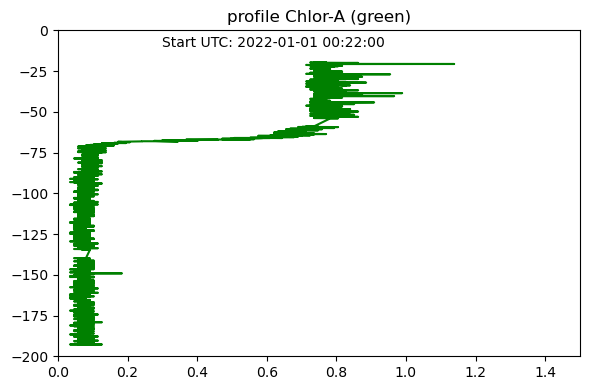

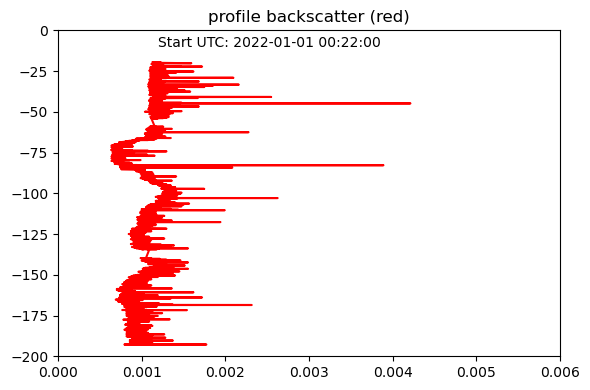

In [11]:
ds_fdom        = xr.open_dataset('./data/rca/sensors/osb/fdom_jan_2022.nc')
ds_chlora      = xr.open_dataset('./data/rca/sensors/osb/chlora_jan_2022.nc')
ds_backscatter = xr.open_dataset('./data/rca/sensors/osb/backscatter_jan_2022.nc')

fig, axes = ChartSensor(profiles, ranges['fdom'],        [0], ds_fdom.fdom,               -ds_fdom.depth,        'profile FDOM', 'blue', 'ascent', 6, 4)
fig, axes = ChartSensor(profiles, ranges['chlora'],      [0], ds_chlora.chlora,           -ds_chlora.depth,      'profile Chlor-A', 'green', 'ascent', 6, 4)
fig, axes = ChartSensor(profiles, ranges['backscatter'], [0], ds_backscatter.backscatter, -ds_backscatter.depth, 'profile backscatter', 'red', 'ascent', 6, 4)

**Interpretation**: FDOM appears to be a faint or nonexistant signal. Chlorophyll-A shows a strong signal
in the mixed layer and then subsides through a *cline*. Backscatter shows some structure. As above these are
single profile charts. Clearly it will be very interesting to view multiple consecutive profiles.

#### 4 of 10: **optaa** i.e. spectrophotometer 2 signals x 83 channels

In [ ]:
# Not working yet
if False:
    instrument_key = 'optaa'
    for s in osb_profiler_streams: 
        if instrument_key in s: 
            print('Found this instrument stream:', s)
            instrument_stream = s
            break
        
    ds = loadData(instrument_stream)                      # lazy load
    t0, t1 = '2022-01-01T00', '2022-12-31T23'             # January 2022
    ds = ds.sel(time=slice(t0, t1))                       # Subset the full time range to one month
    print(ds.time[0], '              ', ds.time[-1])      # verify selected one month time range
    ds                                                    # get a 'data variable' list of sensors/metadata for this instrument

...paused here: This will require unique code to retain the wavelength dimension...

#### 5 of 10: **parad** i.e. PAR (photosynthetically available radiation)

In [12]:
if False:
    instrument_key = 'parad'
    for s in osb_profiler_streams: 
        if instrument_key in s: 
            print('Found this instrument stream:', s)
            print('Compare:                      ooi-data/RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample') 
            instrument_stream = s
            break

In [13]:
if False:
    ds = loadData(instrument_stream)                      # lazy load
    t0, t1 = '2022-01-01T00', '2022-12-31T23'             # January 2022
    ds = ds.sel(time=slice(t0, t1))                       # Subset the full time range to one month
    print(ds.time[0], '              ', ds.time[-1])      # verify selected one month time range
    ds                                                    # get a 'data variable' list of sensors/metadata for this instrument

***seems to fail: kernel restart (timeout?)***


Compare: Joe says this stream is ok: `RS01SBPS-SF01A-3C-PARADA101-streamed-parad_sa_sample` and use a bigger machine.

#### 6 of 10: **spkir** i.e. spectral irradiance

In [ ]:
if False:
    instrument_key = 'spkir'
    for s in osb_profiler_streams: 
        if instrument_key in s: 
            print('Found this instrument stream:', s)
            instrument_stream = s
            break

    ds = loadData(instrument_stream)                      # lazy load
    t0, t1 = '2022-01-01T00', '2022-12-31T23'             # January 2022
    ds = ds.sel(time=slice(t0, t1))                       # Subset the full time range to one month
    print(ds.time[0], '              ', ds.time[-1])      # verify selected one month time range
    ds                                                    # get a 'data variable' list of sensors/metadata for this instrument

***seems to fail: kernel restart (timeout?)***

#### 7 of 10: **nutnr_a_dark_sample** i.e. nitrate explain dark

In [14]:
if doIngest: 
    instrument_key = 'nutnr_a_dark_sample'
    for s in osb_profiler_streams: 
        if instrument_key in s: 
            print('Found this instrument stream:', s)
            instrument_stream = s
            break

    ds = loadData(instrument_stream)                      # lazy load
    t0, t1 = '2022-01-01T00', '2022-12-31T23'             # January 2022
    ds = ds.sel(time=slice(t0, t1))                       # Subset the full time range to one month
    print(ds.time[0], '              ', ds.time[-1])      # verify selected one month time range
    ds                                                    # get a 'data variable' list of sensors/metadata for this instrument

Found this instrument stream: ooi-data/RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_dark_sample
<xarray.DataArray 'time' ()>
array('2022-01-01T07:22:05.457853440', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-01-01T07:22:05.457853440
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time                <xarray.DataArray 'time' ()>
array('2022-12-31T21:48:35.696192512', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-12-31T21:48:35.696192512
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time


**The dark sample nitrate is on hold pending an explanation of what is going on.** 
Presuming it was business as usual, maybe: `nutnr_nitrogen_in_nitrate` becomes `nitrate_dark` and `int_ctd_pressure` becomes depth.

Attempting 1 charts



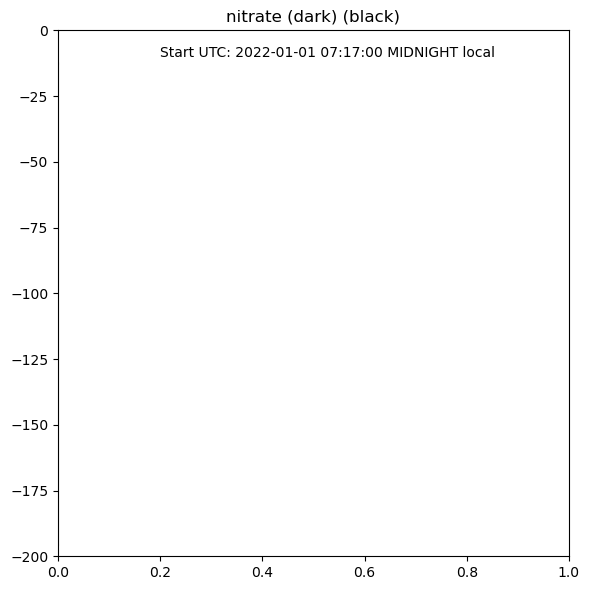

In [15]:
if doIngest:
    t0, t1 = '2022-01-01T00', '2022-01-31T23'
    ds_nitrate_dark, reply    = ShallowProfilerDataReduce(ds, t0, t1, ['nitrate_concentration', 'int_ctd_pressure'], ['nitrate_dark', 'depth'])
    ds_nitrate_dark.to_netcdf('./data/rca/sensors/osb/nitrate_dark_jan_2022.nc')

ds_nitrate_dark    = xr.open_dataset('./data/rca/sensors/osb/nitrate_dark_jan_2022.nc')
fig, axes = ChartSensor(profiles, [0, 1],     [3], ds_nitrate_dark.nitrate_dark, -ds_nitrate_dark.depth, 'nitrate (dark)', 'black', 'ascent', 6, 6)

#### 8 of 10: **nutnr_a_sample** i.e. nitrate

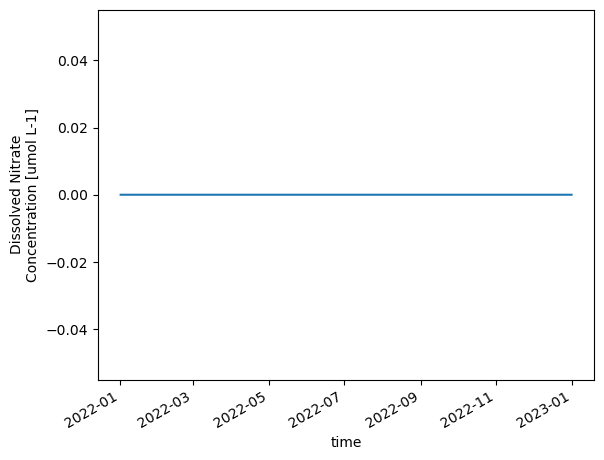

In [16]:
ds.nitrate_concentration.plot()

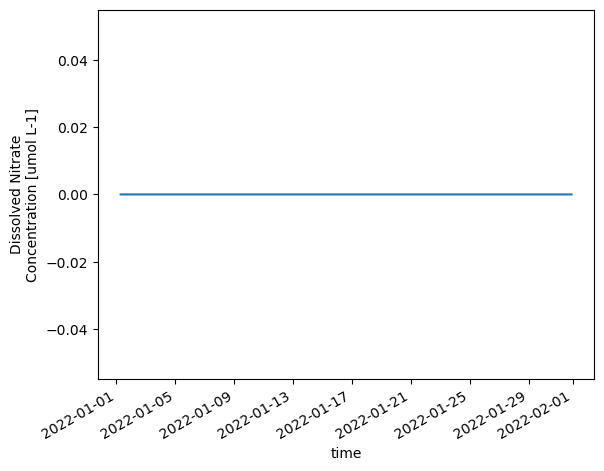

In [17]:
ds_nitrate_dark.nitrate_dark.plot()

In [18]:
if doIngest:
    instrument_key = 'nutnr_a_sample'
    for s in osb_profiler_streams: 
        if instrument_key in s: 
            print('Found this instrument stream:', s)
            instrument_stream = s
            break

    ds = loadData(instrument_stream)                      # lazy load
    t0, t1 = '2022-01-01T00', '2022-12-31T23'             # January 2022
    ds = ds.sel(time=slice(t0, t1))                       # Subset the full time range to one month
    print(ds.time[0], '              ', ds.time[-1])      # verify selected one month time range
    ds                                                    # get a 'data variable' list of sensors/metadata for this instrument

Found this instrument stream: ooi-data/RS01SBPS-SF01A-4A-NUTNRA101-streamed-nutnr_a_sample
<xarray.DataArray 'time' ()>
array('2022-01-01T07:22:07.611640320', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-01-01T07:22:07.611640320
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time                <xarray.DataArray 'time' ()>
array('2022-12-31T21:48:02.217944576', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-12-31T21:48:02.217944576
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time


`salinity_corrected_nitrate` > `nitrate` and `int_ctd_pressure` > `depth`

Attempting 1 charts



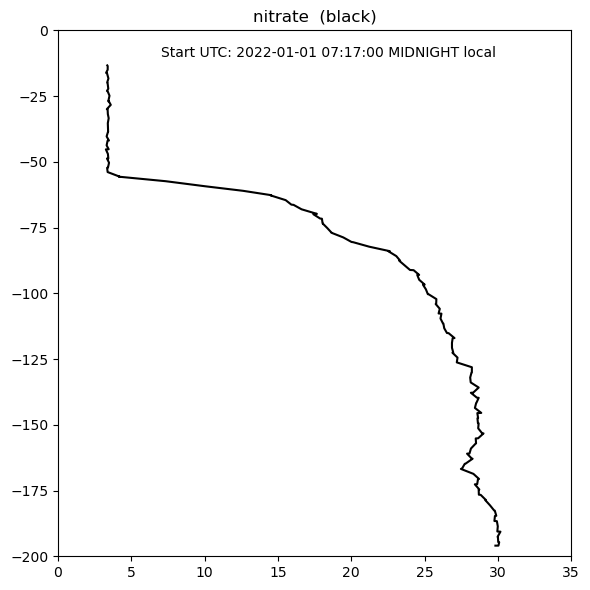

In [19]:
if doIngest:
    t0, t1 = '2022-01-01T00', '2022-01-31T23'
    ds_nitrate, reply    = ShallowProfilerDataReduce(ds, t0, t1, ['salinity_corrected_nitrate', 'int_ctd_pressure'], ['nitrate', 'depth'])
    ds_nitrate.to_netcdf('./data/rca/sensors/osb/nitrate_jan_2022.nc')

ds_nitrate = xr.open_dataset('./data/rca/sensors/osb/nitrate_jan_2022.nc')
fig, axes = ChartSensor(profiles, ranges['nitrate'], [3], ds_nitrate.nitrate, -ds_nitrate.depth,    'nitrate ', 'black', 'ascent', 6, 6)

#### 9 of 10: **velpt** i.e. current velocity

In [20]:
instrument_key = 'velpt'
for s in osb_profiler_streams: 
    if instrument_key in s: 
        print('Found this instrument stream:', s)
        instrument_stream = s
        break
        
ds = loadData(instrument_stream)                      # lazy load
t0, t1 = '2022-01-01T00', '2022-12-31T23'             # January 2022
ds = ds.sel(time=slice(t0, t1))                       # Subset the full time range to one month
print(ds.time[0], '              ', ds.time[-1])      # verify selected one month time range
ds                                                    # get a 'data variable' list of sensors/metadata for this instrument

Found this instrument stream: ooi-data/RS01SBPS-SF01A-4B-VELPTD102-streamed-velpt_velocity_data
<xarray.DataArray 'time' ()>
array('2022-01-01T00:00:00.527429120', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-01-01T00:00:00.527429120
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time                <xarray.DataArray 'time' ()>
array('2022-12-31T23:59:59.845964288', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-12-31T23:59:59.845964288
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time


<xarray.Dataset>
Dimensions:                                 (time: 29325960)
Coordinates:
  * time                                    (time) datetime64[ns] 2022-01-01T...
Data variables: (12/40)
    amplitude_beam1                         (time) float32 ...
    amplitude_beam2                         (time) float32 ...
    amplitude_beam3                         (time) float32 ...
    analog1                                 (time) float32 ...
    battery_voltage_dv                      (time) float32 ...
    ctdpf_sbe43_sample-depth                (time) float64 ...
    ...                                      ...
    velpt_d_northward_velocity              (time) float64 ...
    velpt_d_northward_velocity_qc_executed  (time) uint8 ...
    velpt_d_northward_velocity_qc_results   (time) uint8 ...
    velpt_d_upward_velocity                 (time) float64 ...
    velpt_d_upward_velocity_qc_executed     (time) uint8 ...
    velpt_d_upward_velocity_qc_results      (time) uint8 ...
Attributes: (12/62)
    AssetManagementRecordLastModified:  2024-07-04T16:24:19.204000
    AssetUniqueID:                      ATAPL-70114-00004
    Conventions:                        CF-1.6
    Description:                        Single Point Velocity Meter: VELPT Se...
    FirmwareVersion:                    Not specified.
    Manufacturer:                       Nortek
    ...                                 ...
    stream:                             velpt_velocity_data
    subsite:                            RS01SBPS
    summary:                            Dataset Generated by Stream Engine fr...
    time_coverage_end:                  2024-07-15T11:16:01.879897600
    time_coverage_start:                2014-10-06T23:32:22.570285568
    title:                              Data produced by Stream Engine versio...

For the current sensor: 
depth: `int_ctd_pressure`. Velocities: `velpt_d_upward_velocity`, `velpt_d_northward_velocity`, `velpt_d_eastward_velocity`.
Respectively `depth`, `up`, `north`, `east`

Attempting 1 charts

Attempting 1 charts

Attempting 1 charts



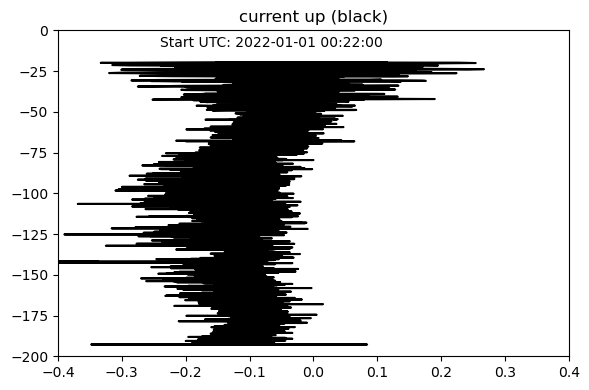

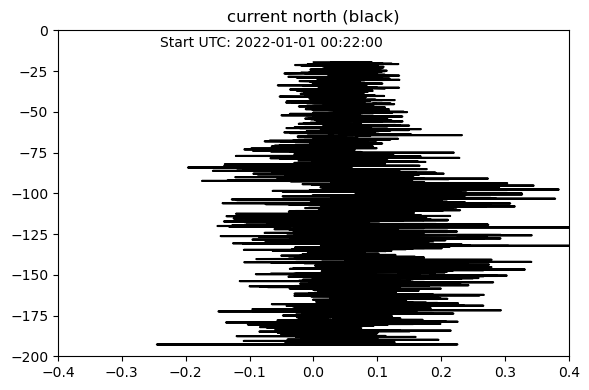

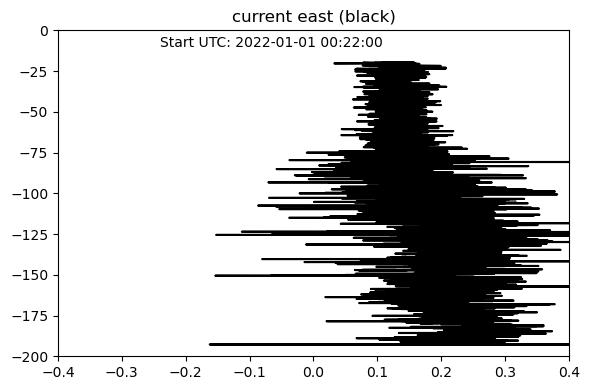

In [21]:
if doIngest:
    t0, t1 = '2022-01-01T00', '2022-01-31T23'
    ds_up, reply    = ShallowProfilerDataReduce(ds, t0, t1, ['velpt_d_upward_velocity',    'int_ctd_pressure'], ['up', 'depth'])
    ds_north, reply = ShallowProfilerDataReduce(ds, t0, t1, ['velpt_d_northward_velocity', 'int_ctd_pressure'], ['north', 'depth'])
    ds_east, reply  = ShallowProfilerDataReduce(ds, t0, t1, ['velpt_d_eastward_velocity',  'int_ctd_pressure'], ['east', 'depth'])

    ds_up.to_netcdf('./data/rca/sensors/osb/up_jan_2022.nc')
    ds_north.to_netcdf('./data/rca/sensors/osb/north_jan_2022.nc')
    ds_east.to_netcdf('./data/rca/sensors/osb/east_jan_2022.nc')
    
    
ds_up    = xr.open_dataset('./data/rca/sensors/osb/up_jan_2022.nc')
ds_north = xr.open_dataset('./data/rca/sensors/osb/north_jan_2022.nc')
ds_east  = xr.open_dataset('./data/rca/sensors/osb/east_jan_2022.nc')

fig, axes = ChartSensor(profiles, ranges['up'],     [0], ds_up.up,       -ds_up.depth,    'current up', 'black', 'ascent', 6, 4)
fig, axes = ChartSensor(profiles, ranges['north'],  [0], ds_north.north, -ds_north.depth, 'current north', 'black', 'ascent', 6, 4)
fig, axes = ChartSensor(profiles, ranges['east'],   [0], ds_east.east,   -ds_east.depth,  'current east', 'black', 'ascent', 6, 4)

#### 10 of 10: **pco2w** i.e. pCO2

In [22]:
if doIngest: 
    instrument_key = 'pco2w'
    for s in osb_profiler_streams: 
        if instrument_key in s: 
            print('Found this instrument stream:', s)
            instrument_stream = s
            break
        
    ds = loadData(instrument_stream)                      # lazy load
    t0, t1 = '2022-01-01T00', '2022-12-31T23'             # January 2022
    ds = ds.sel(time=slice(t0, t1))                       # Subset the full time range to one month
    print(ds.time[0], '              ', ds.time[-1])      # verify selected one month time range
    ds                                                    # get a 'data variable' list of sensors/metadata for this instrument

Found this instrument stream: ooi-data/RS01SBPS-SF01A-4F-PCO2WA101-streamed-pco2w_a_sami_data_record
<xarray.DataArray 'time' ()>
array('2022-01-01T02:16:20.634201088', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-01-01T02:16:20.634201088
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time                <xarray.DataArray 'time' ()>
array('2022-12-31T23:26:46.404636160', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-12-31T23:26:46.404636160
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time


**descent, midnight and noon** `pco2_seawater` > `pco2` and `int_ctd_pressure` > `depth`.

Attempting 4 charts



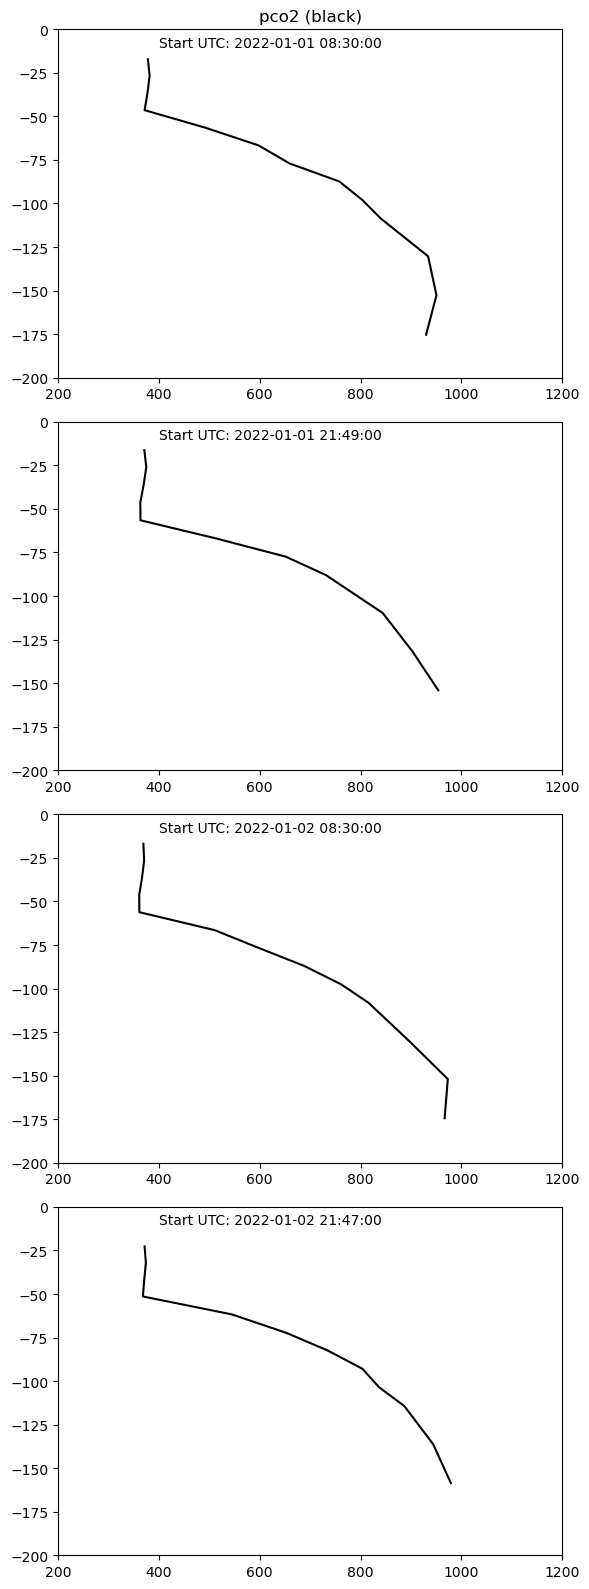

In [23]:
if doIngest:
    t0, t1 = '2022-01-01T00', '2022-01-31T23'
    ds_pco2, reply = ShallowProfilerDataReduce(ds, t0, t1, ['pco2_seawater', 'int_ctd_pressure'], ['pco2', 'depth'])
    ds_pco2.to_netcdf('./data/rca/sensors/osb/pco2_jan_2022.nc')

ds_pco2   = xr.open_dataset('./data/rca/sensors/osb/pco2_jan_2022.nc')
fig, axes = ChartSensor(profiles, ranges['pco2'], [3, 8, 12, 17], ds_pco2.pco2,       -ds_pco2.depth,    'pco2', 'black', 'descent', 6, 4)